In [3]:
import pickle
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas_ta as ta

In [4]:
def column_name_preprocesing(df):
    df = df.copy()
    # df['<DATE>'] = pd.to_datetime(df['<DATE>'])
    df.rename(columns={'<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<VOL>': 'volume', '<TICKER>':'symbol','<DATE>':'datetime'}, inplace=True)
    columns_to_keep = ['symbol', 'datetime', 'open', 'close', 'high', 'low', 'volume']
    df = df[columns_to_keep]
    df.sort_values(by = ['symbol','datetime'], inplace = True)
    df['change_in_price'] = df['close'].diff()
    return df

def rsi(df, n = 14):
    df = df.copy()
    up_df, down_df = df[['symbol','change_in_price']].copy(), df[['symbol','change_in_price']].copy()
    up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    relative_strength = ewma_up / ewma_down
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
    df[f'down_days_{n}'] = down_df['change_in_price']
    df[f'up_days_{n}'] = up_df['change_in_price']
    df[f'RSI_{n}'] = relative_strength_index
    return df

def stochastic_oscillator(df, n = 14):
    df = df.copy()
    low_n, high_n = df[['symbol','low']].copy(), df[['symbol','high']].copy()
    low_n = low_n.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
    high_n = high_n.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())
    k_percent = 100 * ((df['close'] - low_n) / (high_n - low_n))
    df[f'low_{n}'] = low_n
    df[f'high_{n}'] = high_n
    df[f'k_percent_{n}'] = k_percent
    return df

def williams_percent_r(df, n =14):
    df = df.copy()
    low_n, high_n = df[['symbol','low']].copy(), df[['symbol','high']].copy()
    low_n = low_n.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
    high_n = high_n.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())
    r_percent = ((high_n - df['close']) / (high_n - low_n)) * - 100
    df[f'r_percent_{n}'] = r_percent
    return df

def macd(df):
    df = df.copy()
    ema_26 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
    ema_12 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span = 9).mean()
    df['MACD'] = macd
    df['MACD_EMA'] = ema_9_macd
    return df

def price_rate(df, n = 9):
    df = df.copy()
    df[f'Price_Rate_Of_Change_{n}'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))
    return df

def obv(df):
    df = df.copy()
    volume = df['volume']
    change = df['close'].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    df['on_balance_volume'] = pd.Series(obv_values, index = df.index)
    return df

In [33]:
# result = column_name_preprocesing(result)
# mask = result['symbol'] != result['symbol'].shift(1)
# result['change_in_price'] = np.where(mask == True, np.nan, result['change_in_price'])
# result[result.isna().any(axis = 1)]


In [138]:
# df = pd.read_csv('./data/MOEX_daily_010210_010124.txt', sep=',')
df = column_name_preprocesing(df)
price_data =  df

In [139]:
df = price_data
df = rsi(df)
df = stochastic_oscillator(df)
df = williams_percent_r(df)
df = macd(df)
df = price_rate(df)
df = obv(df)

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)
df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=20)

price_data = df

In [140]:
price_data

,symbol,datetime,open,close,high,low,volume,change_in_price,down_days_14,up_days_14,...,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change_9,on_balance_volume,garman_klass_vol,atr
0,MOEX,20130215,58.15,55.00,58.15,51.23,5897620,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,0.006828,NaN
1,MOEX,20130218,55.00,56.02,56.60,54.18,2767350,1.02,0.00,1.02,...,NaN,NaN,NaN,NaN,0.022885,0.012714,NaN,2767350,0.000824,NaN
2,MOEX,20130219,56.50,56.00,56.60,55.95,1761230,-0.02,0.02,0.00,...,NaN,NaN,NaN,NaN,0.028539,0.019200,NaN,1006120,0.000036,NaN
3,MOEX,20130220,56.30,55.40,56.50,54.98,1413600,-0.60,0.60,0.00,...,NaN,NaN,NaN,NaN,0.008749,0.015659,NaN,-407480,0.000272,NaN
4,MOEX,20130221,55.03,54.70,55.39,54.41,519330,-0.70,0.70,0.00,...,NaN,NaN,NaN,NaN,-0.030044,0.002064,NaN,-926810,0.000145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,MOEX,20231225,194.38,192.61,195.85,191.03,5763240,-1.39,1.39,0.00,...,184.28,206.0,38.351750,-61.648250,-1.030428,-0.655819,0.034759,244778320,0.000278,5.307455
2721,MOEX,20231226,192.53,191.90,193.32,190.54,2863400,-0.71,0.71,0.00,...,184.28,206.0,35.082873,-64.917127,-1.248220,-0.774299,0.022049,241914920,0.000101,5.181083
2722,MOEX,20231227,192.30,190.00,192.89,189.49,3108940,-1.90,1.90,0.00,...,184.28,206.0,26.335175,-73.664825,-1.556197,-0.930679,-0.012474,238805980,0.000102,5.092028
2723,MOEX,20231228,190.03,189.31,191.00,186.21,3487730,-0.69,0.69,0.00,...,184.28,206.0,23.158379,-76.841621,-1.834798,-1.111502,-0.027184,235318250,0.000317,5.076927


In [141]:
close_groups = price_data.groupby('symbol')['close']
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))
price_data['target'] = close_groups
price_data['target'] = df['target'].replace(0, -1)

In [142]:
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
price_data = price_data.dropna()
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
price_data

Before NaN Drop we have 2725 rows and 22 columns
After NaN Drop we have 2705 rows and 22 columns


,symbol,datetime,open,close,high,low,volume,change_in_price,down_days_14,up_days_14,...,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change_9,on_balance_volume,garman_klass_vol,atr,target
20,MOEX,20130318,52.75,52.85,53.43,51.10,1133650,-2.15,2.15,0.00,...,55.24,42.270531,-57.729469,-0.076431,-0.095011,0.000947,4990230,0.000993,1.365734,-1.0
21,MOEX,20130319,53.20,51.96,53.20,51.87,1403920,-0.89,0.89,0.00,...,55.24,20.772947,-79.227053,-0.215030,-0.119193,-0.033302,3586310,0.000106,1.363025,-1.0
22,MOEX,20130320,52.20,52.12,52.36,50.76,1013200,0.16,0.00,0.16,...,55.24,30.357143,-69.642857,-0.309100,-0.157400,-0.031227,4599510,0.000481,1.380541,1.0
23,MOEX,20130321,52.57,52.13,52.96,51.95,407400,0.01,0.00,0.01,...,55.24,30.580357,-69.419643,-0.377827,-0.201695,-0.034451,5006910,0.000158,1.353792,1.0
24,MOEX,20130322,52.30,51.94,52.30,51.56,455650,-0.19,0.19,0.00,...,55.24,26.339286,-73.660714,-0.440034,-0.249543,-0.038148,4551260,0.000083,1.310446,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,MOEX,20231225,194.38,192.61,195.85,191.03,5763240,-1.39,1.39,0.00,...,206.00,38.351750,-61.648250,-1.030428,-0.655819,0.034759,244778320,0.000278,5.307455,-1.0
2721,MOEX,20231226,192.53,191.90,193.32,190.54,2863400,-0.71,0.71,0.00,...,206.00,35.082873,-64.917127,-1.248220,-0.774299,0.022049,241914920,0.000101,5.181083,-1.0
2722,MOEX,20231227,192.30,190.00,192.89,189.49,3108940,-1.90,1.90,0.00,...,206.00,26.335175,-73.664825,-1.556197,-0.930679,-0.012474,238805980,0.000102,5.092028,-1.0
2723,MOEX,20231228,190.03,189.31,191.00,186.21,3487730,-0.69,0.69,0.00,...,206.00,23.158379,-76.841621,-1.834798,-1.111502,-0.027184,235318250,0.000317,5.076927,-1.0


In [143]:
X_Cols = price_data.drop(['MACD_EMA', 'symbol', 'datetime', 'open', 'close', 'high', 'low', 'volume', 'change_in_price', 'down_days_14', 'up_days_14', 'low_14', 'high_14','target'], axis = 1)
# X_Cols = price_data.drop(['MACD_EMA', 'symbol', 'datetime', 'open', 'close', 'high', 'low', 'volume', 'change_in_price', 'down_days_28', 'up_days_28', 'low_28', 'high_28', 'down_days_14', 'up_days_14', 'low_14', 'high_14','target'], axis = 1)

Y_Cols = price_data['target']

X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

In [152]:
list(X_train.columns)

['RSI_14',
 'k_percent_14',
 'r_percent_14',
 'MACD',
 'Price_Rate_Of_Change_9',
 'on_balance_volume',
 'garman_klass_vol',
 'atr']

#### Random Forest

In [144]:
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf.fit(X_train, y_train)
y_pred = rand_frst_clf.predict(X_test)

print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  67.94682422451994


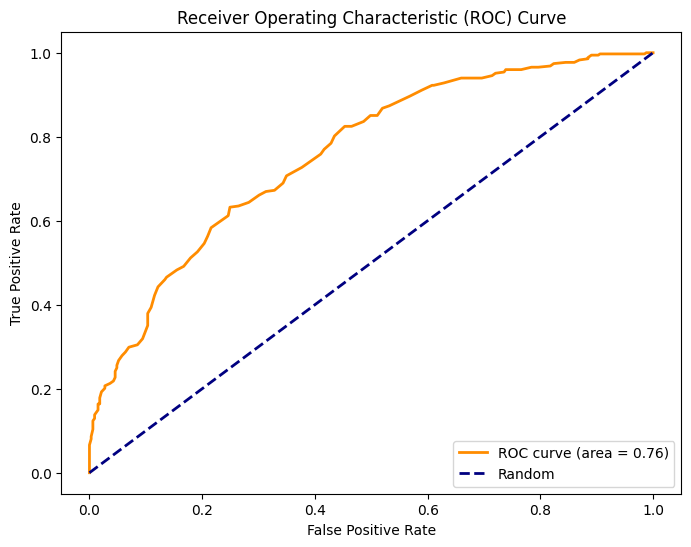

In [145]:
y_scores = rand_frst_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Random Forest + Randomized Search

In [81]:
# n_estimators = list(range(50, 2000, 50))
n_estimators = list(range(200, 2000, 100))
max_features = ['auto', 'sqrt', None, 'log2']
max_depth = list(range(10, 110, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10, 20, 30, 40]
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
69 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

Correct Prediction (%):  68.43657817109144


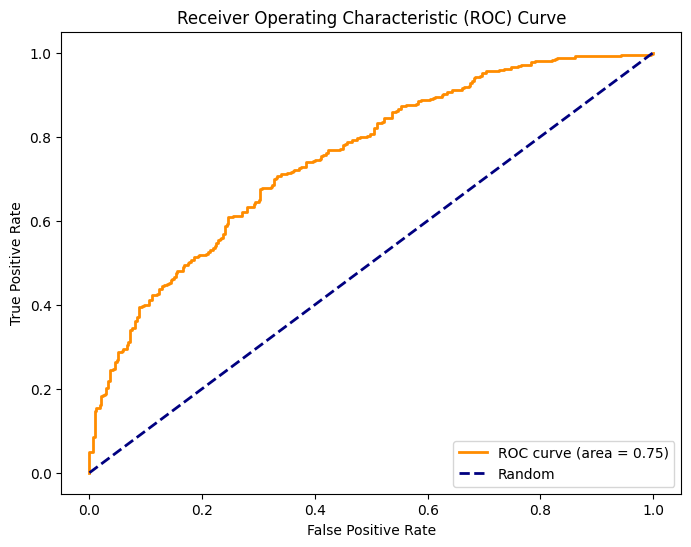

In [83]:
y_scores = rf_random.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
base_classifier = DecisionTreeClassifier(max_depth=1)
ada_boost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)
ada_boost_classifier.fit(X_train, y_train)
y_pred = ada_boost_classifier.predict(X_test)

print('Correct Prediction (%): ', accuracy_score(y_test, ada_boost_classifier.predict(X_test), normalize = True) * 100.0)

#### AdaBoost

In [146]:
base_classifier = DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)
ada_boost.fit(X_train, y_train)
y_pred = ada_boost.predict(X_test)

print('Correct Prediction (%): ', accuracy_score(y_test, ada_boost.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  66.91285081240767


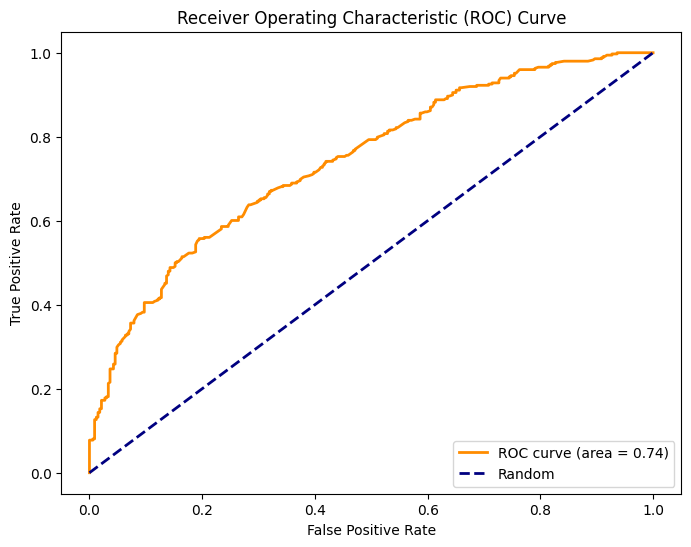

In [147]:
y_scores = ada_boost.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### AdaBoost + Randomized Search

In [148]:
my_list = np.logspace(-2, 0, num=100, endpoint=True)
my_list = [round(x, 2) for x in my_list]
my_list = list(set(my_list))

param_dist = {
    'base_estimator__max_depth': list(range(1, 21, 1)),
    'n_estimators': list(range(10, 300, 10)),
    'learning_rate': my_list
}

base_classifier = DecisionTreeClassifier()
ada_boost = AdaBoostClassifier(base_classifier)

ada_boost_random = RandomizedSearchCV(ada_boost, param_distributions=param_dist, n_iter=100, cv=3, random_state=42, n_jobs = -1)
ada_boost_random.fit(X_train, y_train)

print('Correct Prediction (%): ', accuracy_score(y_test, ada_boost_random.predict(X_test), normalize = True) * 100.0)

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:930: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  self.best_estimator_ = clone(base_estimator).set_params(


Correct Prediction (%):  68.09453471196456


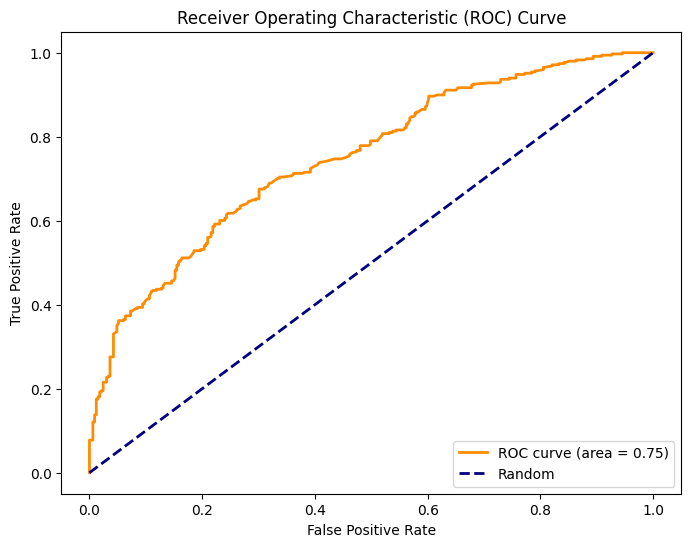

In [149]:
y_scores = ada_boost_random.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [1]:
import pickle

In [2]:
with open('adaboost_model.pkl', 'wb') as model_file:
    pickle.dump(ada_boost_random, model_file)

NameError: name 'ada_boost_random' is not defined